# Decision Analysis

Think Bayes, Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [98]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [99]:
# Get utils.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

In [100]:
from utils import set_pyplot_params
set_pyplot_params()

This chapter presents a problem inspired by the game show *The Price is Right*.
It is a silly example, but it demonstrates a useful process called Bayesian [decision analysis](https://en.wikipedia.org/wiki/Decision_analysis).

As in previous examples, we'll use data and prior distribution to compute a posterior distribution; then we'll use the posterior distribution to choose an optimal strategy in a game that involves bidding.

As part of the solution, we will use kernel density estimation (KDE) to estimate the prior distribution, and a normal distribution to compute the likelihood of the data.

And at the end of the chapter, I pose a related problem you can solve as an exercise.

## The Price Is Right Problem

On November 1, 2007, contestants named Letia and Nathaniel appeared on *The Price is Right*, an American television game show. They competed in a game called "The Showcase", where the objective is to guess the price of a collection of prizes. The contestant who comes closest to the actual price, without going over, wins the prizes.

Nathaniel went first. His showcase included a dishwasher, a wine cabinet, a laptop computer, and a car. He bid \\$26,000.

Letia's showcase included a pinball machine, a video arcade game, a pool table, and a cruise of the Bahamas. She bid \\$21,500.

The actual price of Nathaniel's showcase was \\$25,347. His bid was too high, so he lost.

The actual price of Letia's showcase was \\$21,578. 

She was only off by \\$78, so she won her showcase and, because her bid was off by less than 250, she also won Nathaniel's showcase.

For a Bayesian thinker, this scenario suggests several questions:

1. Before seeing the prizes, what prior beliefs should the contestants have about the price of the showcase?

2. After seeing the prizes, how should the contestants update those beliefs?

3. Based on the posterior distribution, what should the contestants bid?

The third question demonstrates a common use of Bayesian methods: decision analysis.

This problem is inspired by [an example](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb) in Cameron Davidson-Pilon's book, [*Probablistic Programming and Bayesian Methods for Hackers*](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).

## The Prior

To choose a prior distribution of prices, we can take advantage of data from previous episodes. Fortunately, [fans of the show keep detailed records](https://web.archive.org/web/20121107204942/http://www.tpirsummaries.8m.com/). 

For this example, I downloaded files containing the price of each showcase from the 2011 and 2012 seasons and the bids offered by the contestants.

The following cells load the data files.

In [101]:
# Load the data files

download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2011.csv')
download('https://raw.githubusercontent.com/AllenDowney/ThinkBayes2/master/data/showcases.2012.csv')

The following function reads the data and cleans it up a little.

In [102]:
import pandas as pd

def read_data(filename):
    """Read the showcase price data."""
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

I'll read both files and concatenate them.

In [103]:
df2011 = read_data('showcases.2011.csv')
df2012 = read_data('showcases.2012.csv')

df = pd.concat([df2011, df2012], ignore_index=True)

In [104]:
print(df2011.shape, df2012.shape, df.shape)

(191, 6) (122, 6) (313, 6)


In [196]:
df2011.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
Sep. 19,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
Sep. 20,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
Sep. 21,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
Sep. 22,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
Sep. 23,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


Here's what the dataset looks like:

In [105]:
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0


In [198]:
df.describe()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
count,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,30299.488818,31047.680511,26183.092652,27371.789137,4116.396166,3675.891374
std,7145.705405,8293.059002,6470.507122,6303.572665,6899.909806,6886.260711
min,19563.000000,18349.000000,5500.000000,15000.000000,-14187.000000,-25839.000000
25%,24866.000000,25264.000000,22000.000000,23000.000000,26.000000,-587.000000
50%,28958.000000,29488.000000,25620.000000,27000.000000,3902.000000,3136.000000
75%,34428.000000,34665.000000,29900.000000,30777.000000,7800.000000,7829.000000
max,58342.000000,71628.000000,50972.000000,59900.000000,31374.000000,43628.000000


The first two columns, `Showcase 1` and `Showcase 2`, are the values of the showcases in dollars.
The next two columns are the bids the contestants made.
The last two columns are the differences between the actual values and the bids.

## Kernel Density Estimation

This dataset contains the prices for 313 previous showcases, which we can think of as a sample from the population of possible prices.

We can use this sample to estimate the prior distribution of showcase prices.  One way to do that is kernel density estimation (KDE), which uses the sample to estimate a smooth distribution.  If you are not familiar with KDE, you can [read about it here](https://mathisonian.github.io/kde).

SciPy provides `gaussian_kde`, which takes a sample and returns an object that represents the estimated distribution.

The following function takes `sample`, makes a KDE, evaluates it at a given sequence of quantities, `qs`, and returns the result as a normalized PMF.

In [106]:
from scipy.stats import gaussian_kde
from empiricaldist import Pmf

def kde_from_sample(sample, qs):
    """Make a kernel density estimate from a sample."""
    kde = gaussian_kde(sample)
    ps = kde(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

We can use it to estimate the distribution of values for Showcase 1:

<Axes: >

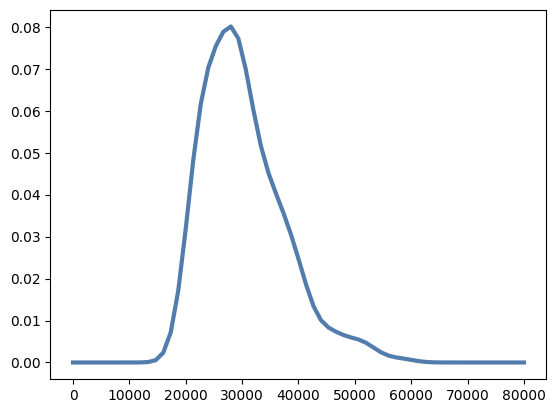

In [207]:
qs = np.linspace(0, 80000, 61)
kde = gaussian_kde(df['Showcase 1'])
ps = kde(qs)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.plot()

<Axes: >

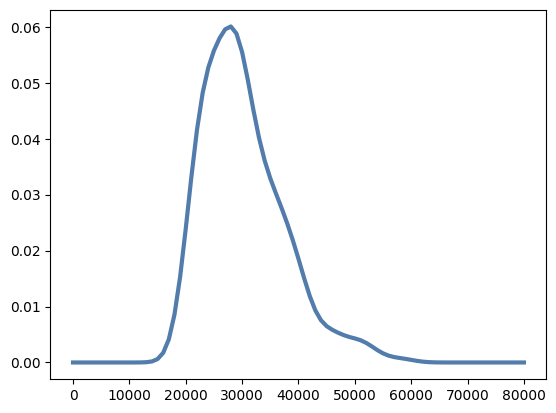

In [208]:
import numpy as np

qs = np.linspace(0, 80000, 81)
prior1 = kde_from_sample(df['Showcase 1'], qs)
prior1.plot()

Here's what it looks like:

In [209]:
from utils import decorate

def decorate_value(title=''):
    decorate(xlabel='Showcase value ($)',
        ylabel='PMF',
        title=title)

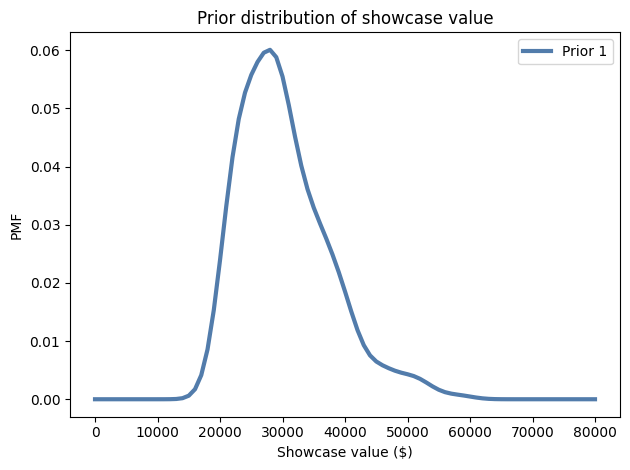

In [210]:
prior1.plot(label='Prior 1')
decorate_value('Prior distribution of showcase value')

**Exercise:** Use this function to make a `Pmf` that represents the prior distribution for Showcase 2, and plot it.

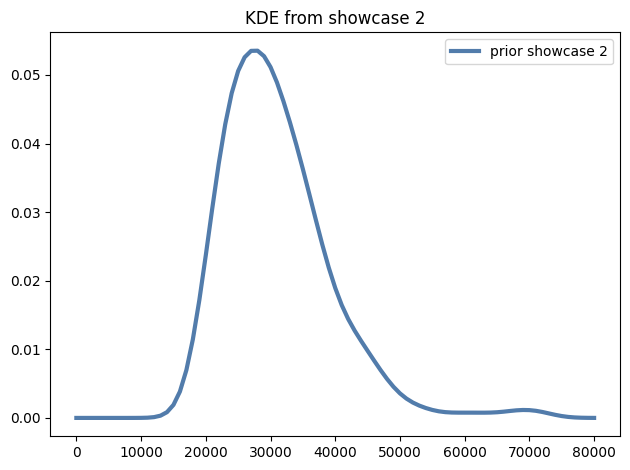

In [216]:
# Solution goes here
qs = np.linspace(0, 80000, 81)
prior2 = kde_from_sample(df['Showcase 2'],qs)
prior2.plot(label="prior showcase 2")
decorate(title = "KDE from showcase 2")

In [111]:
# Solution goes here

## Distribution of Error

To update these priors, we have to answer these questions:

* What data should we consider and how should we quantify it?

* Can we compute a likelihood function; that is, for each hypothetical price, can we compute the conditional likelihood of the data?

To answer these questions, I will model each contestant as a price-guessing instrument with known error characteristics. 
In this model, when the contestant sees the prizes, they guess the price of each prize and add up the prices.
Let's call this total `guess`.

Now the question we have to answer is, "If the actual price is `price`, what is the likelihood that the contestant's guess would be `guess`?"

Equivalently, if we define `error = guess - price`, we can ask, "What is the likelihood that the contestant's guess is off by `error`?"

To answer this question, I'll use the historical data again. 
For each showcase in the dataset, let's look at the difference between the contestant's bid and the actual price:

In [218]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

To visualize the distribution of these differences, we can use KDE again.

In [222]:
qs = np.linspace(-40000, 20000, 61)
kde_diff1 = kde_from_sample(sample_diff1, qs)
kde_diff2 = kde_from_sample(sample_diff2, qs)

Here's what these distributions look like:

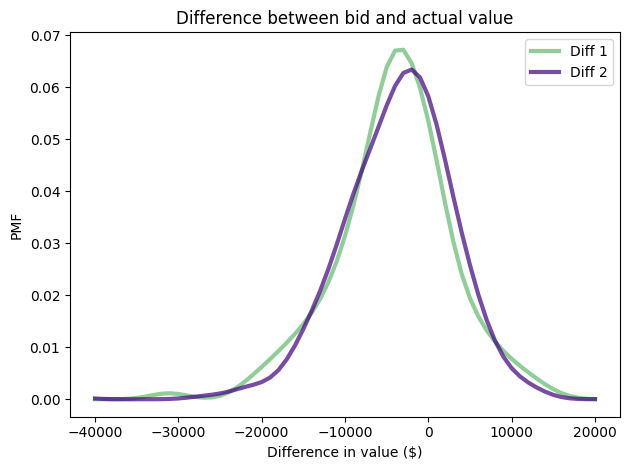

In [224]:
kde_diff1.plot(label='Diff 1', color='C8')
kde_diff2.plot(label='Diff 2', color='C4')

decorate(xlabel='Difference in value ($)',
        ylabel='PMF',
        title='Difference between bid and actual value')

It looks like the bids are too low more often than too high, which makes sense.  Remember that under the rules of the game, you lose if you overbid, so contestants probably underbid to some degree deliberately.

For example, if they guess that the value of the showcase is \\$40,000, they might bid \\$36,000 to avoid going over.

It looks like these distributions are well modeled by a normal distribution, so we can summarize them with their mean and standard deviation.

For example, here is the mean and standard deviation of `Diff` for Player 1.

In [225]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

print(mean_diff1, std_diff1)

-4116.3961661341855 6899.909806377117


Now we can use these differences to model the contestant's distribution of errors.
This step is a little tricky because we don't actually know the contestant's guesses; we only know what they bid.

So we have to make some assumptions:

* I'll assume that contestants underbid because they are being strategic, and that on average their guesses are accurate.  In other words, the mean of their errors is 0.

* But I'll assume that the spread of the differences reflects the actual spread of their errors.  So, I'll use the standard deviation of the differences as the standard deviation of their errors.

Based on these assumptions, I'll make a normal distribution with parameters 0 and `std_diff1`.

SciPy provides an object called `norm` that represents a normal distribution with the given mean and standard deviation.

In [226]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)

The result is an object that provides `pdf`, which evaluates the probability density function of the normal distribution.

For example, here is the probability density of `error=-100`, based on the distribution of errors for Player 1.

In [229]:
error = -100
#NOTE:  probability densities are not probabilities but are proportional, so we can use them as likelihoods.
error_dist1.pdf(error)

5.781240564008691e-05

By itself, this number doesn't mean very much, because probability densities are not probabilities. But they are proportional to probabilities, so we can use them as likelihoods in a Bayesian update, as we'll see in the next section.

## Update

Suppose you are Player 1.  You see the prizes in your showcase and your guess for the total price is \\$23,000.

From your guess I will subtract away each hypothetical price in the prior distribution; the result is your error under each hypothesis.

In [230]:
guess1 = 23000
error1 = guess1 - prior1.qs

Now suppose we know, based on past performance, that your estimation error is well modeled by `error_dist1`.
Under that assumption we can compute the likelihood of your error under each hypothesis.

In [231]:
likelihood1 = error_dist1.pdf(error1)

The result is an array of likelihoods, which we can use to update the prior.

In [232]:
posterior1 = prior1 * likelihood1
posterior1.normalize()

3.3889812097254624e-05

Here's what the posterior distribution looks like:

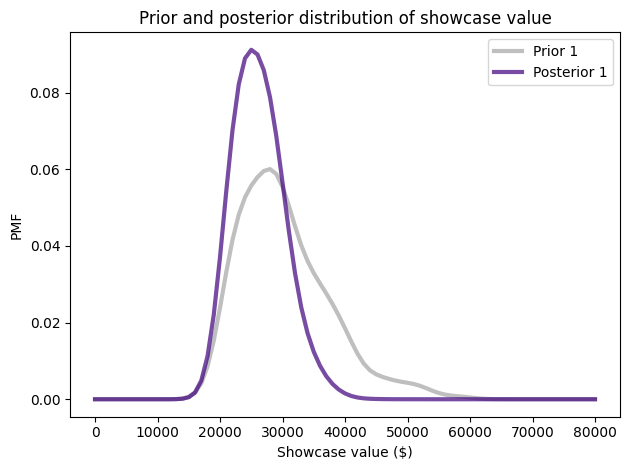

In [121]:
prior1.plot(color='C5', label='Prior 1')
posterior1.plot(color='C4', label='Posterior 1')

decorate_value('Prior and posterior distribution of showcase value')

Because your initial guess is in the lower end of the range, the posterior distribution has shifted to the left.  We can compute the posterior mean to see by how much.

In [233]:
prior1.mean(), posterior1.mean()

(30299.488817891375, 26192.024002392536)

Before you saw the prizes, you expected to see a showcase with a value close to \\$30,000.
After making a guess of \\$23,000, you updated the prior distribution.
Based on the combination of the prior and your guess, you now expect the actual price to be about \\$26,000.

**Exercise:** Now suppose you are Player 2.  When you see your showcase, you guess that the total price is \\$38,000.

Use `diff2` to construct a normal distribution that represents the distribution of your estimation errors.

Compute the likelihood of your guess for each actual price and use it to update `prior2`.

Plot the posterior distribution and compute the posterior mean.  Based on the prior and your guess, what do you expect the actual price of the showcase to be?

In [123]:
# Solution goes here

In [124]:
# Solution goes here

In [125]:
# Solution goes here

In [126]:
# Solution goes here

In [127]:
# Solution goes here

In [128]:
# Solution goes here

## Probability of Winning

Now that we have a posterior distribution for each player, let's think about strategy.

First, from the point of view of Player 1, let's compute the probability that Player 2 overbids.  To keep it simple, I'll use only the performance of past players, ignoring the value of the showcase. 

The following function takes a sequence of past bids and returns the fraction that overbid.

In [129]:
def prob_overbid(sample_diff):
    """Compute the probability of an overbid."""
    return np.mean(sample_diff > 0)

Here's an estimate for the probability that Player 2 overbids.

In [130]:
prob_overbid(sample_diff2)

0.29073482428115016

Now suppose Player 1 underbids by \\$5000.
What is the probability that Player 2 underbids by more?

The following function uses past performance to estimate the probability that a player underbids by more than a given amount, `diff`:

In [131]:
def prob_worse_than(diff, sample_diff):
    """Probability opponent diff is worse than given diff."""
    return np.mean(sample_diff < diff)

Here's the probability that Player 2 underbids by more than \\$5000.

In [132]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

And here's the probability they underbid by more than \\$10,000.

In [133]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

We can combine these functions to compute the probability that Player 1 wins, given the difference between their bid and the actual price:

In [134]:
def compute_prob_win(diff, sample_diff):
    """Probability of winning for a given diff."""
    # if you overbid you lose
    if diff > 0:
        return 0
    
    # if the opponent overbids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    
    # p1 and p2 are mutually exclusive, so we can add them
    return p1 + p2

Here's the probability that you win, given that you underbid by \\$5000.

In [135]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

Now let's look at the probability of winning for a range of possible differences.

In [136]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) 
      for x in xs]

Here's what it looks like:

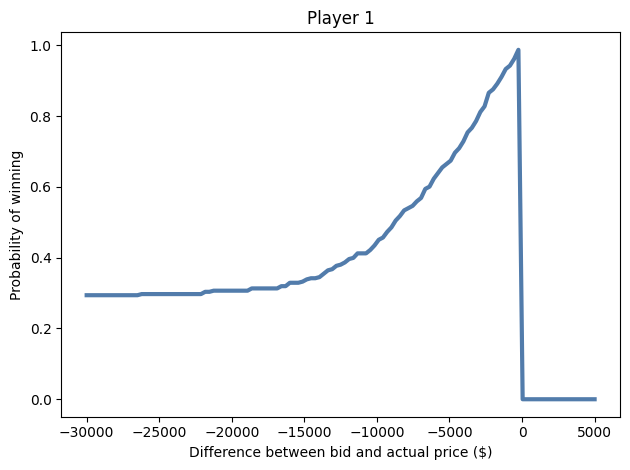

In [137]:
import matplotlib.pyplot as plt

plt.plot(xs, ys)

decorate(xlabel='Difference between bid and actual price ($)',
         ylabel='Probability of winning',
         title='Player 1')

If you underbid by \\$30,000, the chance of winning is about 30%, which is mostly the chance your opponent overbids.

As your bids gets closer to the actual price, your chance of winning approaches 1.

And, of course, if you overbid, you lose (even if your opponent also overbids).

**Exercise:** Run the same analysis from the point of view of Player 2.  Using the sample of differences from Player 1, compute:

1. The probability that Player 1 overbids.

2. The probability that Player 1 underbids by more than \\$5000.

3. The probability that Player 2 wins, given that they underbid by \\$5000.

Then plot the probability that Player 2 wins for a range of possible differences between their bid and the actual price.

In [138]:
# Solution goes here

In [139]:
# Solution goes here

In [140]:
# Solution goes here

In [141]:
# Solution goes here

In [142]:
# Solution goes here

## Decision Analysis

In the previous section we computed the probability of winning, given that we have underbid by a particular amount.

In reality the contestants don't know how much they have underbid by, because they don't know the actual price.

But they do have a posterior distribution that represents their beliefs about the actual price, and they can use that to estimate their probability of winning with a given bid.

The following function takes a possible bid, a posterior distribution of actual prices, and a sample of differences for the opponent.

It loops through the hypothetical prices in the posterior distribution and, for each price,

1. Computes the difference between the bid and the hypothetical price,

2. Computes the probability that the player wins, given that difference, and

3. Adds up the weighted sum of the probabilities, where the weights are the probabilities in the posterior distribution. 

In [143]:
def total_prob_win(bid, posterior, sample_diff):
    """Computes the total probability of winning with a given bid.

    bid: your bid
    posterior: Pmf of showcase value
    sample_diff: sequence of differences for the opponent
    
    returns: probability of winning
    """
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff)
    return total

This loop implements the law of total probability:

$$P(win) = \sum_{price} P(price) ~ P(win ~|~ price)$$

Here's the probability that Player 1 wins, based on a bid of \\$25,000 and the posterior distribution `posterior1`.

In [144]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439812

Now we can loop through a series of possible bids and compute the probability of winning for each one.

In [145]:
bids = posterior1.qs

probs = [total_prob_win(bid, posterior1, sample_diff2) 
         for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

Here are the results.

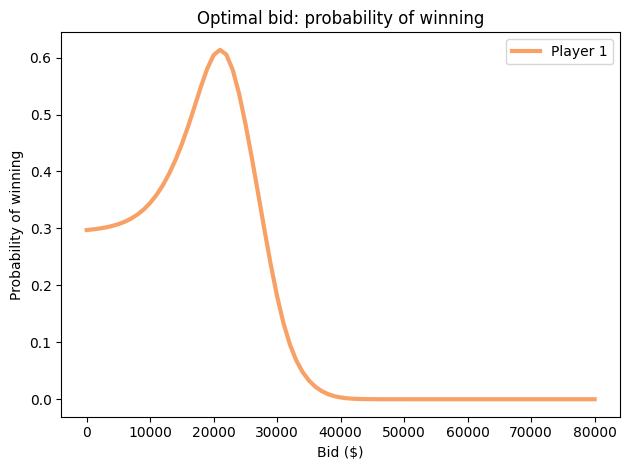

In [146]:
prob_win_series.plot(label='Player 1', color='C1')

decorate(xlabel='Bid ($)',
         ylabel='Probability of winning',
         title='Optimal bid: probability of winning')

And here's the bid that maximizes Player 1's chance of winning.

In [147]:
prob_win_series.idxmax()

21000.0

In [148]:
prob_win_series.max()

0.6136807192359474

Recall that your guess was \\$23,000.
Using your guess to compute the posterior distribution, the posterior mean is about \\$26,000.
But the bid that maximizes your chance of winning is \\$21,000.

**Exercise:** Do the same analysis for Player 2.

In [149]:
# Solution goes here

In [150]:
# Solution goes here

In [151]:
# Solution goes here

In [152]:
# Solution goes here

## Maximizing Expected Gain

In the previous section we computed the bid that maximizes your chance of winning.
And if that's your goal, the bid we computed is optimal.

But winning isn't everything.
Remember that if your bid is off by \\$250 or less, you win both showcases.
So it might be a good idea to increase your bid a little: it increases the chance you overbid and lose, but it also increases the chance of winning both showcases.

Let's see how that works out.
The following function computes how much you will win, on average, given your bid, the actual price, and a sample of errors for your opponent.

In [153]:
def compute_gain(bid, price, sample_diff):
    """Compute expected gain given a bid and actual price."""
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

For example, if the actual price is \\$35000 
and you bid \\$30000, 
you will win about \\$23,600 worth of prizes on average, taking into account your probability of losing, winning one showcase, or winning both.

In [154]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In reality we don't know the actual price, but we have a posterior distribution that represents what we know about it.
By averaging over the prices and probabilities in the posterior distribution, we can compute the expected gain for a particular bid.

In this context, "expected" means the average over the possible showcase values, weighted by their probabilities.

In [155]:
def expected_gain(bid, posterior, sample_diff):
    """Compute the expected gain of a given bid."""
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

For the posterior we computed earlier, based on a guess of \\$23,000, the expected gain for a bid of \\$21,000 is about \\$16,900.

In [156]:
expected_gain(21000, posterior1, sample_diff2)

16923.59933856512

But can we do any better? 

To find out, we can loop through a range of bids and find the one that maximizes expected gain.

In [157]:
bids = posterior1.qs

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

Here are the results.

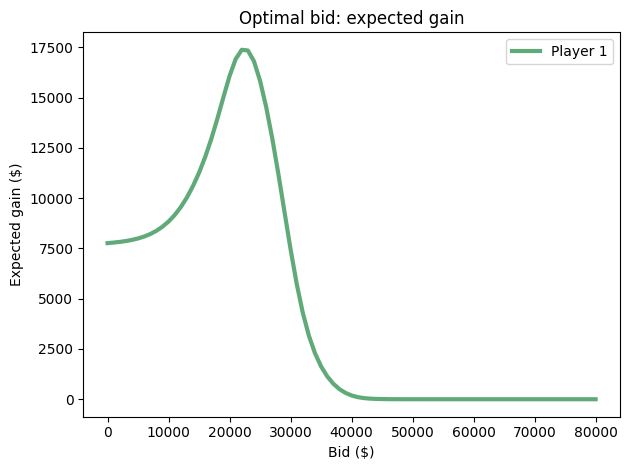

In [158]:
expected_gain_series.plot(label='Player 1', color='C2')

decorate(xlabel='Bid ($)',
         ylabel='Expected gain ($)',
         title='Optimal bid: expected gain')

Here is the optimal bid.

In [159]:
expected_gain_series.idxmax()

22000.0

With that bid, the expected gain is about \\$17,400.

In [160]:
expected_gain_series.max()

17384.899584430797

Recall that your initial guess was \\$23,000.
The bid that maximizes the chance of winning is \\$21,000.
And the bid that maximizes your expected gain is \\$22,000.

**Exercise:** Do the same analysis for Player 2.

In [161]:
# Solution goes here

In [162]:
# Solution goes here

In [163]:
# Solution goes here

In [164]:
# Solution goes here

## Summary

There's a lot going on this this chapter, so let's review the steps:

1. First we used KDE and data from past shows to estimate prior distributions for the values of the showcases.

2. Then we used bids from past shows to model the distribution of errors as a normal distribution.

3. We did a Bayesian update using the distribution of errors to compute the likelihood of the data.

4. We used the posterior distribution for the value of the showcase to compute the probability of winning for each possible bid, and identified the bid that maximizes the chance of winning.

5. Finally, we used probability of winning to compute the expected gain for each possible bid, and identified the bid that maximizes expected gain.

Incidentally, this example demonstrates the hazard of using the word "optimal" without specifying what you are optimizing.
The bid that maximizes the chance of winning is not generally the same as the bid that maximizes expected gain.

## Discussion

When people discuss the pros and cons of Bayesian estimation, as contrasted with classical methods sometimes called "frequentist", they often claim that in many cases Bayesian methods and frequentist methods produce the same results.

In my opinion, this claim is mistaken because Bayesian and frequentist method produce different *kinds* of results:

* The result of frequentist methods is usually a single value that is considered to be the best estimate (by one of several criteria) or an interval that quantifies the precision of the estimate.

* The result of Bayesian methods is a posterior distribution that represents all possible outcomes and their probabilities.

Granted, you can use the posterior distribution to choose a "best" estimate or compute an interval.
And in that case the result might be the same as the frequentist estimate.

But doing so discards useful information and, in my opinion, eliminates the primary benefit of Bayesian methods: the posterior distribution is more useful than a single estimate, or even an interval.

The example in this chapter demonstrates the point.
Using the entire posterior distribution, we can compute the bid that maximizes the probability of winning, or the bid that maximizes expected gain, even if the rules for computing the gain are complicated (and nonlinear).

With a single estimate or an interval, we can't do that, even if they are "optimal" in some sense.
In general, frequentist estimation provides little guidance for decision-making.

If you hear someone say that Bayesian and frequentist methods produce the same results, you can be confident that they don't understand Bayesian methods.

## Exercises

**Exercise:** When I worked in Cambridge, Massachusetts, I usually took the subway to South Station and then a commuter train home to Needham.  Because the subway was unpredictable, I left the office early enough that I could wait up to 15 minutes and still catch the commuter train.

When I got to the subway stop, there were usually about 10 people waiting on the platform.  If there were fewer than that, I figured I just missed a train, so I expected to wait a little longer than usual.  And if there there more than that, I expected another train soon.

But if there were a *lot* more than 10 passengers waiting, I inferred that something was wrong, and I expected a long wait.  In that case, I might leave and take a taxi.

We can use Bayesian decision analysis to quantify the analysis I did intuitively.  Given the number of passengers on the platform, how long should we expect to wait?  And when should we give up and take a taxi?

My analysis of this problem is in `redline.ipynb`, which is in the repository for this book.  [Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/notebooks/redline.ipynb).

**Exercise:**  This exercise is inspired by a true story.  In 2001 I created [Green Tea Press](https://greenteapress.com) to publish my books, starting with *Think Python*.  I ordered 100 copies from a short run printer and made the book available for sale through a distributor.  

After the first week, the distributor reported that 12 copies were sold.  Based that report, I thought I would run out of copies in about 8 weeks, so I got ready to order more.  My printer offered me a discount if I ordered more than 1000 copies, so I went a little crazy and ordered 2000.  

A few days later, my mother called to tell me that her *copies* of the book had arrived.  Surprised, I asked how many.  She said ten.

It turned out I had sold only two books to non-relatives.  And it took a lot longer than I expected to sell 2000 copies.

The details of this story are unique, but the general problem is something almost every retailer has to figure out.  Based on past sales, how do you predict future sales?  And based on those predictions, how do you decide how much to order and when?

Often the cost of a bad decision is complicated.  If you place a lot of small orders rather than one big one, your costs are likely to be higher.  If you run out of inventory, you might lose customers.  And if you order too much, you have to pay the various costs of holding inventory.

So, let's solve a version of the problem I faced.  It will take some work to set up the problem; the details are in the notebook for this chapter.

Suppose you start selling books online.  During the first week you sell 10 copies (and let's assume that none of the customers are your mother).  During the second week you sell 9 copies.

Assuming that the arrival of orders is a Poisson process, we can think of the weekly orders as samples from a Poisson distribution with an unknown rate.
We can use orders from past weeks to estimate the parameter of this distribution, generate a predictive distribution for future weeks, and compute the order size that maximized expected profit.

* Suppose the cost of printing the book is \\$5 per copy, 

* But if you order 100 or more, it's \\$4.50 per copy.

* For every book you sell, you get \\$10.

* But if you run out of books before the end of 8 weeks, you lose \\$50 in future sales for every week you are out of stock.

* If you have books left over at the end of 8 weeks, you lose \\$2 in inventory costs per extra book.

For example, suppose you get orders for 10 books per week, every week. If you order 60 books, 

* The total cost is \\$300.  

* You sell all 60 books, so you make \\$600.  

* But the book is out of stock for two weeks, so you lose \\$100 in future sales.

In total, your profit is \\$200.

If you order 100 books,

* The total cost is \\$450.

* You sell 80 books, so you make \\$800.

* But you have 20 books left over at the end, so you lose \\$40.

In total, your profit is \\$310.

Combining these costs with your predictive distribution, how many books should you order to maximize your expected profit?

To get you started, the following functions compute profits and costs according to the specification of the problem:

In [165]:
def print_cost(printed):
    """Compute print costs.
    
    printed: integer number printed
    """
    if printed < 100:
        return printed * 5
    else:
        return printed * 4.5

In [166]:
def total_income(printed, orders):
    """Compute income.
    
    printed: integer number printed
    orders: sequence of integer number of books ordered
    """
    sold = min(printed, np.sum(orders))
    return sold * 10

In [167]:
def inventory_cost(printed, orders):
    """Compute inventory costs.
    
    printed: integer number printed
    orders: sequence of integer number of books ordered
    """
    excess = printed - np.sum(orders)
    if excess > 0:
        return excess * 2
    else:
        return 0

In [168]:
def out_of_stock_cost(printed, orders):
    """Compute out of stock costs.
    
    printed: integer number printed
    orders: sequence of integer number of books ordered
    """
    weeks = len(orders)
    total_orders = np.cumsum(orders)
    for i, total in enumerate(total_orders):
        if total > printed:
            return (weeks-i) * 50
    return 0

In [169]:
def compute_profit(printed, orders):
    """Compute profit.
    
    printed: integer number printed
    orders: sequence of integer number of books ordered
    """
    return (total_income(printed, orders) -
            print_cost(printed)-
            out_of_stock_cost(printed, orders) -
            inventory_cost(printed, orders))

To test these functions, suppose we get exactly 10 orders per week for eight weeks:

In [170]:
always_10 = [10] * 8
always_10

[10, 10, 10, 10, 10, 10, 10, 10]

If you print 60 books, your net profit is \\$200, as in the example.

In [171]:
compute_profit(60, always_10)

200

If you print 100 books, your net profit is \\$310.

In [172]:
compute_profit(100, always_10)

310.0

Of course, in the context of the problem you don't know how many books will be ordered in any given week.  You don't even know the average rate of orders.  However, given the data and some assumptions about the prior, you can compute the distribution of the rate of orders.

You'll have a chance to do that, but to demonstrate the decision analysis part of the problem, I'll start with the arbitrary assumption that order rates come from a gamma distribution with mean 9.

Here's a `Pmf` that represents this distribution.

In [173]:
from scipy.stats import gamma

alpha = 9
qs = np.linspace(0, 25, 101)
ps = gamma.pdf(qs, alpha)
pmf = Pmf(ps, qs)
pmf.normalize()
pmf.mean()

8.998788382371902

And here's what it looks like:

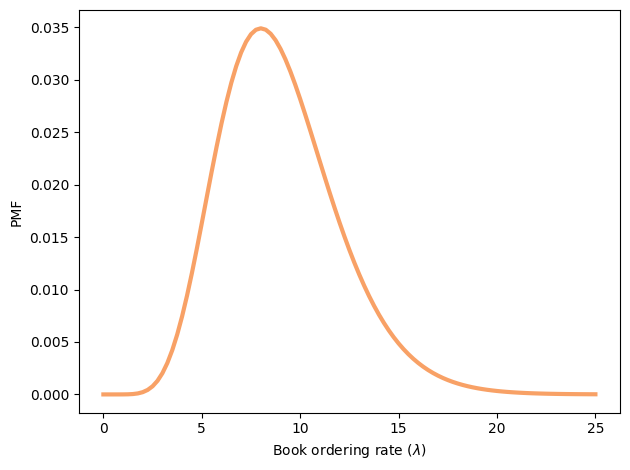

In [174]:
pmf.plot(color='C1')
decorate(xlabel=r'Book ordering rate ($\lambda$)',
        ylabel='PMF')

Now, we *could* generate a predictive distribution for the number of books ordered in a given week, but in this example we have to deal with a complicated cost function.  In particular, `out_of_stock_cost` depends on the sequence of orders.

So, rather than generate a predictive distribution, I suggest we run simulations.  I'll demonstrate the steps.

First, from our hypothetical distribution of rates, we can draw a random sample of 1000 values. 

In [175]:
rates = pmf.choice(1000)
np.mean(rates)

8.9315

For each possible rate, we can generate a sequence of 8 orders.

In [176]:
np.random.seed(17)
order_array = np.random.poisson(rates, size=(8, 1000)).transpose()
order_array[:5, :]

array([[ 8,  5, 12,  9,  7,  8,  9,  4],
       [15, 12,  3,  9,  9, 17, 13, 16],
       [11, 10,  5,  8, 12, 11,  7, 11],
       [ 7,  4, 10, 11, 11, 10,  8,  9],
       [ 8, 10,  8,  7,  7,  9,  7,  8]])

Each row of this array is a hypothetical sequence of orders based on a different hypothetical order rate.

Now, if you tell me how many books you printed, I can compute your expected profits, averaged over these 1000 possible sequences.

In [177]:
def compute_expected_profits(printed, order_array):
    """Compute profits averaged over a sample of orders.
    
    printed: number printed
    order_array: one row per sample, one column per week
    """
    profits = [compute_profit(printed, orders)
               for orders in order_array]
    return np.mean(profits)

For example, here are the expected profits if you order 70, 80, or 90 books.

In [178]:
compute_expected_profits(70, order_array)

185.68

In [179]:
compute_expected_profits(80, order_array)

181.342

In [180]:
compute_expected_profits(90, order_array)

157.194

Now, let's sweep through a range of values and compute expected profits as a function of the number of books you print.

In [181]:
printed_array = np.arange(70, 110)
t = [compute_expected_profits(printed, order_array)
                    for printed in printed_array]
expected_profits = pd.Series(t, printed_array)

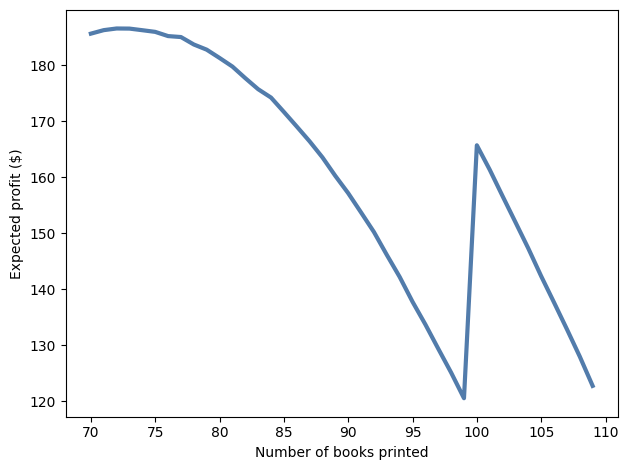

In [182]:
expected_profits.plot(label='')

decorate(xlabel='Number of books printed',
         ylabel='Expected profit ($)')

Here is the optimal order and the expected profit.

In [183]:
expected_profits.idxmax(), expected_profits.max()

(72, 186.602)

Now it's your turn.  Choose a prior that you think is reasonable, update it with the data you are given, and then use the posterior distribution to do the analysis I just demonstrated.

In [184]:
# Solution goes here

In [185]:
# Solution goes here

In [186]:
# Solution goes here

In [187]:
# Solution goes here

In [188]:
# Solution goes here

In [189]:
# Solution goes here

In [190]:
# Solution goes here

In [191]:
# Solution goes here

In [192]:
# Solution goes here

In [193]:
# Solution goes here

In [194]:
# Solution goes here